# Part 3: EM implementation

Ethan Holleman

In [1]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

Urls for data.

In [68]:
# URL for at_gc_sequences.txt - this is a single sequence: ATTTAATATAAAATTTGGCCGCCATAAAAAAA
at_gc_sequences_txt = 'https://ucdavis.box.com/shared/static/s8g6zx9vwxbbfdxdj2uqzhlvslc1jhsy.txt'
# URL for sequence.padded.txt - the real binding site data
sequence_padded_txt = 'https://ucdavis.box.com/shared/static/0cacx2xvn4ugxo9h21ci2ngesryigf43.txt'
# URL for sequence.motiflocation.padded.txt - the location of the binding sites from sequence.padded.txt
sequence_motiflocation_padded_txt = 'https://ucdavis.box.com/shared/static/gd0r12mdkhix86bo9ffbn3dy0fy0prmn.txt'

In [2]:
def read_data():
    with open('sequence.padded.txt') as handle:
        # I dont think this is the actual sequences we should be using
        # put using as placeholder for now.
        return [s.strip() for s in handle.readlines()]

data = read_data()
data[0:3]

['ATACCCCTGGCTGGGTCATGGTGACCTGGAGGAAGCGT',
 'CATATATGGCCAGGGTCAGTGTGACCTCCATTTCCCAT',
 'AGCAGCTGGCCTGGGTCACAGTGACCTGACCTCAAACC']

Create matrix $X_{i,j,p,k}$ using one-hot encoding scheme.

In [3]:
def encode_data(data, motif_length=8):
    seq_length = len(data[0])
    number_motifs = seq_length - motif_length + 1
    X = np.zeros((len(data), number_motifs, motif_length, 4))

    def nuc_to_one_hot(nuc):
        # Convert nucleotide to the index in one hot encoded array
        # that should be hot (==1)
        upper_nuc = nuc.upper()
        mapping = {'A': 0, 'T': 1, 'G': 2, 'C': 3}
        return mapping[upper_nuc]

    for i in range(len(data)):
        for j in range(number_motifs):
            for p in range(motif_length):
                nuc = data[i][j+p]
                k_hot = nuc_to_one_hot(nuc)
                X[i][j][p][k_hot] = 1.0
    
    return X

In [105]:
X.shape

(357, 31, 8, 4)

In [38]:
motif_length = 8
X = encode_data(data, motif_length)
X[0][:2]  # Data for first two motifs of first sequence

array([[[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]],

       [[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]]])

Randomly initialize the model parameters.

In [5]:
def init_EM(seq_length, motif_length):
    number_motifs_per_sequence = seq_length - motif_length + 1
    lambda_j = np.random.uniform(0, 1, size=(number_motifs_per_sequence,))
    lambda_j_norm = lambda_j / lambda_j.sum()
    psi_0 = np.random.uniform(0, 1, size=(4, motif_length))
    psi_1 = np.random.uniform(0, 1, size=(4, motif_length))
    psi_0 = (psi_0/psi_0.sum(axis=0)).T
    psi_1 = (psi_1/psi_1.sum(axis=0)).T
    
    return lambda_j_norm, psi_0, psi_1

In [6]:
lambda_j, psi_0, psi_1 = init_EM(len(data[0]), motif_length)

## E step

![](e.png)

First write a function to calculate numerators of the above equation.

In [106]:
def e_numerator(i, j, X, lambda_j, psi_0, psi_1):
    # i = current sequence
    # j = current j index
    # X = Data
    psi_1_term = X[i][j] * psi_1
    # remove zero terms this is in lieu of having exponent X_{i,j,p,k}
    # whcih would cause 0 encoded values (cold values) to have
    # value of 1 and therefore not contribute to the product
    psi_1_term = psi_1_term[psi_1_term != 0]
    # take product of all remaining terms (these are probibities seeing
    # the bases in the given motif in their given positions given they
    # are in the TFBS)
    psi_1_term = np.log(psi_1_term).sum()
    
    # now need to get product of all other motifs (j' != j) but assuming they are
    # not the TFBS (psi^0). 
    psi_0_term = X[i][np.arange(len(X[i]))!=j] * psi_0
    psi_0_term = psi_0_term.flatten()
    psi_0_term = np.log(psi_0_term[psi_0_term != 0]).sum()
    return np.log(lambda_j[j]) + psi_0_term + psi_1_term  # log of products is sum of logs

In [103]:
psi_1_term = X[0][0] * psi_1
psi_1_term = np.log(psi_1_term[psi_1_term != 0]).sum()

Wrap above function in loop for all $i$ and all $j$.

In [104]:
def e_step(X, lambda_j, psi_0, psi_1):
    posts = []
    for i in range(X.shape[0]):  # number of sequences
        posts.append([])  # add row of js for each sequence i
        for j in range(X.shape[1]):
            posts[i].append(e_numerator(i, j, X, lambda_j, psi_0, psi_1))
        # At this point in the loop we have calculated all numerators for each motif j
        # for a specific sequence i. These are already in log space from `e_numerator`
        # function. Next step in the Quon^{TM} log trick is to subtract the smallest value 
        posts[i] = np.array(posts[i])
        posts[i] = posts[i] - posts[i].min()
        # Now having subtracted the smallest value we are free to go back to linear
        # space by exponentation of all terms in posts[i][j]
        posts[i] = np.e**posts[i] 
        # Now divide (normalize) each term by the denominator which is just the sum of
        # all values in posts[i][j]
        posts[i] = posts[i] / posts[i].sum()
        # Test to make sure the sum across the row (for each sequence) is one (+- rounding)
        assert abs(posts[i].sum() - 1) < 1e-5
        
        
    return np.array(posts)

e_step_1 = e_step(X, lambda_j, psi_0, psi_1)

## ELBO

This guy (complete log likelihood)

![](loglik.png)

Minus entropy term

![](entropy.png)

In [9]:
def calculate_ELBOOOOO(X, posts, lambda_j, psi_0, psi_1):
    
    def lambda_j_term():
        return (posts * np.log(lambda_j)).sum()
    
    def C_ij_term():
        sum_list = []
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                for p in range(X.shape[2]):
                    for k in range(X.shape[3]):
                        sum_list.append(
                            X[i][j][p][k] * (posts[i][j] * np.log(psi_1[p][k]) + (1 - posts[i][j]) * np.log(psi_0[p][k]))
                        )
        return sum(sum_list)
    
    def entropy():
        return (np.log(posts) * posts).sum()
    
    return lambda_j_term() + C_ij_term() - entropy()

## M step

$\boldsymbol{E}[C_{i,j}] = P(C_{i} = j | X_{i}, \theta)$

### $\lambda_{j}$

In [10]:
def lambda_j_m_step(E_Cij):
    return E_Cij.sum(axis=0) / E_Cij.shape[0]

In [11]:
new_lambda_j = lambda_j_m_step(e_step_1)

Check to make sure all terms sum to 1 (within rounding error) for test E step and that shape is preserved.

In [12]:
assert abs(new_lambda_j.sum() - 1) < 1e-5
assert new_lambda_j.shape == lambda_j.shape

### $\psi^{1}_{p, k}$

In [13]:
def psi_1_m_step(X, E_Cij, psi_1):
    new_psi_1 = np.zeros(psi_1.shape)
    for p in range(psi_1.shape[0]):
        for k in range(psi_1.shape[1]):
            numerator_terms = []
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    numerator_terms.append(X[i][j][p][k] * E_Cij[i][j])
            psi_pk = sum(numerator_terms) / X.shape[0]
            new_psi_1[p][k] = psi_pk
    return new_psi_1
            
            
psi_1_pract = psi_1_m_step(X, e_step_1, psi_1)

In [14]:
psi_1_pract

array([[0.17362282, 0.01358685, 0.52277293, 0.29001739],
       [0.20355652, 0.45082343, 0.16276321, 0.18285683],
       [0.07813408, 0.14214357, 0.09957356, 0.68014878],
       [0.73869658, 0.07618579, 0.06067732, 0.12444031],
       [0.1691198 , 0.24501723, 0.2384102 , 0.34745277],
       [0.41286291, 0.25153341, 0.17986759, 0.15573608],
       [0.17629201, 0.26615752, 0.34448566, 0.21306481],
       [0.22732009, 0.37860943, 0.2082504 , 0.18582009],
       [0.10469345, 0.16539572, 0.52276989, 0.20714094],
       [0.29589144, 0.25751226, 0.07184114, 0.37475515],
       [0.15915685, 0.11440867, 0.12665762, 0.59977687],
       [0.51689938, 0.0512732 , 0.10350207, 0.32832535],
       [0.33503859, 0.35998074, 0.17471892, 0.13026175],
       [0.0925206 , 0.13203204, 0.59258987, 0.18285749],
       [0.21981767, 0.25249103, 0.41946437, 0.10822694],
       [0.15953487, 0.30973472, 0.32323258, 0.20749782]])

Test that rows (nucleotide probs) sum to 1.

In [15]:
psi_1_pract

array([[0.17362282, 0.01358685, 0.52277293, 0.29001739],
       [0.20355652, 0.45082343, 0.16276321, 0.18285683],
       [0.07813408, 0.14214357, 0.09957356, 0.68014878],
       [0.73869658, 0.07618579, 0.06067732, 0.12444031],
       [0.1691198 , 0.24501723, 0.2384102 , 0.34745277],
       [0.41286291, 0.25153341, 0.17986759, 0.15573608],
       [0.17629201, 0.26615752, 0.34448566, 0.21306481],
       [0.22732009, 0.37860943, 0.2082504 , 0.18582009],
       [0.10469345, 0.16539572, 0.52276989, 0.20714094],
       [0.29589144, 0.25751226, 0.07184114, 0.37475515],
       [0.15915685, 0.11440867, 0.12665762, 0.59977687],
       [0.51689938, 0.0512732 , 0.10350207, 0.32832535],
       [0.33503859, 0.35998074, 0.17471892, 0.13026175],
       [0.0925206 , 0.13203204, 0.59258987, 0.18285749],
       [0.21981767, 0.25249103, 0.41946437, 0.10822694],
       [0.15953487, 0.30973472, 0.32323258, 0.20749782]])

In [16]:
psi_1_pract.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### $\psi^{0}_{p, k}$

![](psi0.png)

In [17]:
def psi_0_m_step(X, E_Cij, psi_1, seq_length):
    new_psi_1 = np.zeros(psi_1.shape)
    
    motif_length = X.shape[2]
    
    for p in range(psi_1.shape[0]):
        for k in range(psi_1.shape[1]):
            numerator_terms = []
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    numerator_terms.append(
                        X[i][j][p][k] * (1 - E_Cij[i][j])
                    )
            
            psi_pk = sum(numerator_terms) / ((seq_length - motif_length + 1 - 1) * (X.shape[0]))
            new_psi_1[p][k] = psi_pk
            
    return new_psi_1

In [18]:
psi_0_pract = psi_0_m_step(X, e_step_1, psi_1, len(data[0]))

In [19]:
psi_0_pract

array([[0.25121169, 0.25250185, 0.27901325, 0.21727321],
       [0.25901838, 0.22995366, 0.28735594, 0.22367203],
       [0.25771659, 0.23901894, 0.27813245, 0.22513202],
       [0.22119752, 0.23259507, 0.27047851, 0.2757289 ],
       [0.23626486, 0.24401946, 0.25234117, 0.2673745 ],
       [0.21932874, 0.2433413 , 0.26149571, 0.27583425],
       [0.22931802, 0.24254924, 0.25668686, 0.27144587],
       [0.2282718 , 0.23323611, 0.26542585, 0.27306624],
       [0.23359109, 0.24254567, 0.2521481 , 0.27171514],
       [0.22439098, 0.23581209, 0.2734088 , 0.26638813],
       [0.23277069, 0.24027962, 0.27193573, 0.25501396],
       [0.21931079, 0.24658715, 0.27757191, 0.25653016],
       [0.22019241, 0.23039049, 0.27993702, 0.26948008],
       [0.21810162, 0.2520836 , 0.25368544, 0.27612935],
       [0.21855425, 0.2504279 , 0.2379999 , 0.29301795],
       [0.23007971, 0.25966701, 0.21385357, 0.2963997 ]])

In [20]:
psi_0_pract.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Combine all components into one M step to product "theta" term.

In [21]:
def m_step(X, E_Cij, lambda_j, psi_1, psi_0, seq_length):
    return (
        lambda_j_m_step(E_Cij), 
        psi_1_m_step(X, E_Cij, psi_1), 
        psi_0_m_step(X, E_Cij, psi_0, seq_length)
    )

In [22]:
m_step_pract = m_step(X, e_step_1, lambda_j, psi_1, psi_0, len(data[0]))

In [23]:
m_step_pract

(array([0.14987937, 0.06373242, 0.00891826, 0.02827522, 0.00100642,
        0.00041673, 0.10962472, 0.03430062, 0.00834251, 0.00596685,
        0.00112586, 0.00143103, 0.00675624, 0.00049521, 0.3322962 ,
        0.00191144, 0.0537677 , 0.03135262, 0.03549623, 0.03746402,
        0.04041787, 0.01097326, 0.0360492 ]),
 array([[0.17362282, 0.01358685, 0.52277293, 0.29001739],
        [0.20355652, 0.45082343, 0.16276321, 0.18285683],
        [0.07813408, 0.14214357, 0.09957356, 0.68014878],
        [0.73869658, 0.07618579, 0.06067732, 0.12444031],
        [0.1691198 , 0.24501723, 0.2384102 , 0.34745277],
        [0.41286291, 0.25153341, 0.17986759, 0.15573608],
        [0.17629201, 0.26615752, 0.34448566, 0.21306481],
        [0.22732009, 0.37860943, 0.2082504 , 0.18582009],
        [0.10469345, 0.16539572, 0.52276989, 0.20714094],
        [0.29589144, 0.25751226, 0.07184114, 0.37475515],
        [0.15915685, 0.11440867, 0.12665762, 0.59977687],
        [0.51689938, 0.0512732 , 0.10350207,

In [33]:
def run_EM(seed, X, seq_length, number_iters=20):
    np.random.seed(seed)
    log_like = []
    lambda_j, psi_0, psi_1 = init_EM(len(data[0]), motif_length)
    l_0, l_1, stop = 1e7, 0, 1e-4
    counter = 0
    while counter < number_iters:
        E_Cij = e_step(X, lambda_j, psi_0, psi_1)
        lambda_j, psi_0, psi_1 = m_step(X, E_Cij, lambda_j, psi_1, psi_0, seq_length)
        l_0 = l_1
        l_1 = calculate_ELBOOOOO(X, E_Cij, lambda_j, psi_0, psi_1)
        log_like.append(l_1)
        counter += 1
    return lambda_j, psi_1, psi_0, E_Cij, log_like

In [25]:
lambda_j, psi_1, psi_0, E_Cij = run_EM(12345, X, len(data[0]))

-203650.38149689513
-200186.29302565593


In [80]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

# Question 1

Plot the log likelihood as a function of EM iteration, for 20 iterations, for 5 different random initializations of the
model parameter. Does the log likelihood monotonically increase every iteration of every initialization?

In [59]:
def plot_log_likes(X, seq_length, number_iters=20, number_seeds=5):
    records = []
    for i in range(number_seeds):
        np.random.seed(i)
        lambda_j, psi_1, psi_0, E_Cij, log_like = run_EM(i, X, seq_length, number_iters)
        plt.plot(log_like)
        print(f'Seed {i} complete')
        records.append(
            dict(zip(
                ['lambda_j', 'psi_1', 'psi_0', 'E_Cij', 'log_like', 'seed'],
                [lambda_j, psi_1, psi_0, E_Cij, log_like, i]
            ))
        )
    plt.show()
    return records

Seed 0 complete
Seed 1 complete
Seed 2 complete
Seed 3 complete
Seed 4 complete


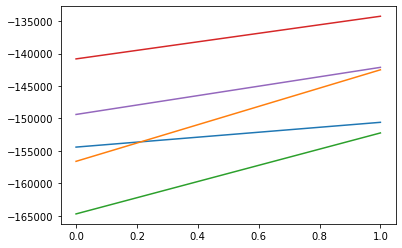

In [60]:
records = plot_log_likes(X, len(data[0]), 2)

# Question 2

draw a sequence logo visualization of the foreground motif your model learns, ψ k,p . You could try LogoMaker, a
Python library (https://logomaker.readthedocs.io/en/latest/). Alternatively, there are a number of web servers
for doing this; you could draw samples from your foreground model, and input those drawn sequences into e.g.
the WebLogo server (https://weblogo.berkeley.edu).

In [42]:
import logomaker
import pandas as pd

In [39]:
lambda_j, psi_1, psi_0, E_Cij, log_like = run_EM(1234, X, len(data[0]), number_iters=5)

In [54]:
def make_logo(psi_1):
    psi_1_df = pd.DataFrame(psi_1, columns=['A', 'T', 'G', 'C'])
    psi_1_df.index.name = 'pos'
    return logomaker.Logo(psi_1_df,
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold'
                         )

findfont: Font family ['Arial Rounded MT Bold'] not found. Falling back to DejaVu Sans.


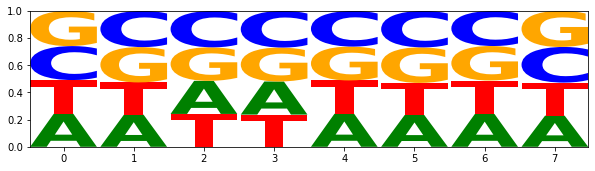

In [55]:
make_logo(psi_1).show()

# Question 3

Now run your model using model random initializations. How do the model parameters ψ k,p compare across runs?
What about their log likelihoods

## Comparison of $\psi$ between different random initializations

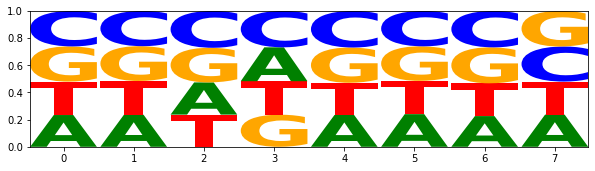

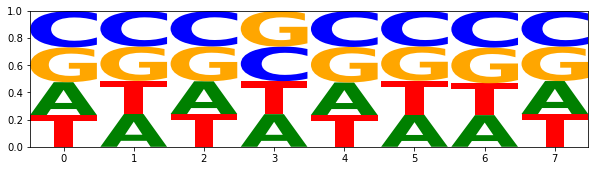

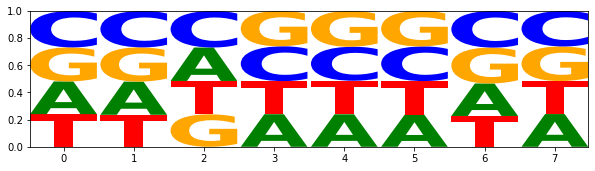

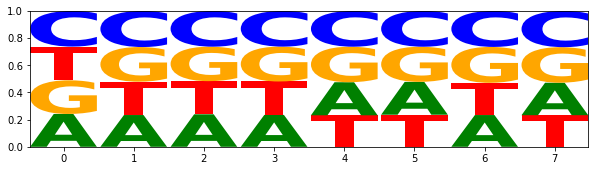

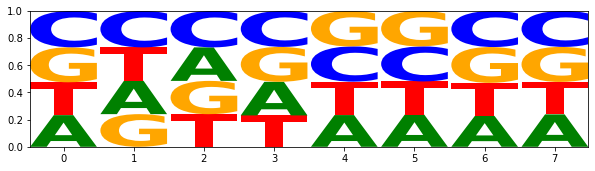

In [65]:
for r in records:
    make_logo(r['psi_1'])

## Comparison of log likelihoods between different random initializations

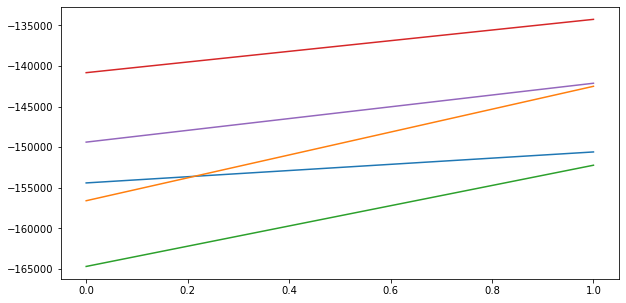

In [81]:
for r in records:
    plt.plot(r['log_like'])
plt.show()

# Question 4

Plot a figure that shows the distribution over C i,j for a few of the input sequences, and compare that (in the
visualization) to the ground truth. How close was your model to predicting the real motif location?

Download motif location data.

In [90]:
import requests
import io
import seaborn as sns

In [70]:
sequence_padded_motifs = pd.read_csv(io.StringIO(requests.get(sequence_motiflocation_padded_txt).text), sep=",", header=None).to_numpy()

In [75]:
sequence_padded_motifs[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

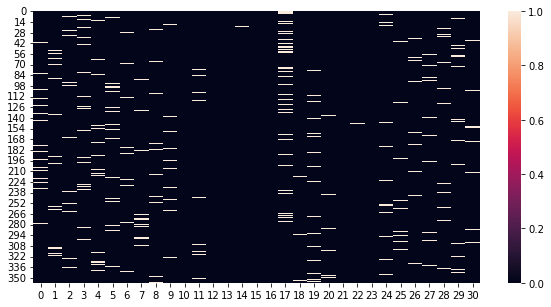

In [97]:
records[0]['E_Cij']
max_prob = np.zeros_like(records[0]['E_Cij'])
max_prob[np.arange(len(records[0]['E_Cij'])), records[0]['E_Cij'].argmax(1)] = 1

ax = sns.heatmap(max_prob)
plt.show()

<AxesSubplot:>

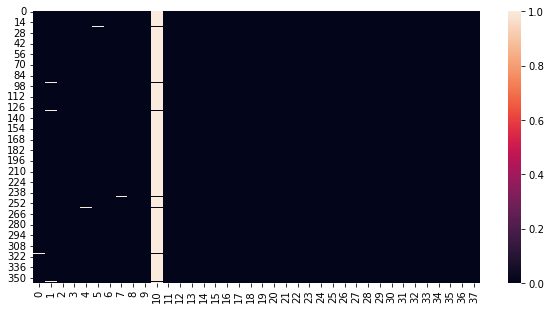

In [98]:
sns.heatmap(sequence_padded_motifs)

# Question 5

Train your model using 80% of the data, holding out the remaining 20%. Evaluate the log likelihood of your held
out data using the model you implemented in this assignment, and compare it to the log likelihood from the simple
latent model we used in class, using the same training/held out data. Which one is better?

In [109]:
def divide_data(X):
    training_split = int(X.shape[0] * 0.80)
    return X[:training_split], X[training_split:]

Train the EM motif model.

In [112]:
X_train, X_test = divide_data(X)

In [113]:
lambda_j, psi_1, psi_0, E_Cij, log_like = run_EM(1234, X_train, len(data[0]), number_iters=5)

# Question 6

Train your model on the atgcsequences.txt file (that had a GC-rich region embedded between two flanking AT-rich
regions). Does the model work better?

# Question 7

The original training set in sequence.padded.txt has 357 sequences. Randomly sample another 357 sequences of
the same length (just from a simple generator, that produces each base at equal frequency) and train the model
with all data. Does it still recover the same motif? What if you add 3000 randomly generated sequences instead?

In [157]:
def random_sequence_generator(*args):
    rand_seqs = [''.join(i) for i in np.random.choice(['A', 'T', 'G', 'C'], size=args)]
    return encode_data(rand_seqs)
        

In [158]:
rand_seqs = random_sequence_generator(X.shape[0], len(data[0]))

In [164]:
mixed_data = np.concatenate((X, rand_seqs))

Train model on mixed data (50% random sequence).

In [165]:
lambda_j, psi_1, psi_0, E_Cij, log_like = run_EM(1234, mixed_data, len(data[0]), number_iters=5)

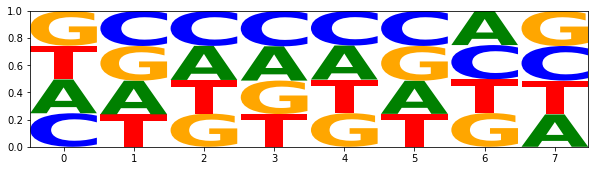

In [166]:
make_logo(psi_1)

Add 3000 randomly generated sequences.

In [167]:
lots_random_seqs = random_sequence_generator(3000, len(data[0]))

In [168]:
dilute_data = np.concatenate((X, lots_random_seqs))

In [ ]:
lambda_j, psi_1, psi_0, E_Cij, log_like = run_EM(1234, mixed_data, len(data[0]), number_iters=5)

In [ ]:
make_logo(psi_1)